In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import plotly_express as px

In [51]:
ngram_range = (1, 2)
n_terms = 4000
n_topics = 10
max_iter = 20
n_top_terms = 9
OHCO = ['book_id', 'chap_num', 'para_num']
PARA = OHCO[:3]
CHAP = OHCO[:2]
BOOK = OHCO[:1]

In [52]:
BAG = CHAP

In [53]:
TOKENS = pd.read_csv('data/LOTR/CORPUS.csv')
TOKENS

book_id  chap_num  para_num  sent_num  token_num token_str  term_str  \
0             1         1         0         0          0   CHAPTER   chapter   
1             1         1         0         0          1       ONE       one   
2             1         1         0         0          2         A         a   
3             1         1         0         0          3      Long      long   
4             1         1         0         0          4  expected  expected   
...         ...       ...       ...       ...        ...       ...       ...   
474403        6         9        15        66          2         I         i   
474404        6         9        15        66          3         m         m   
474405        6         9        15        66          4      back      back   
474406        6         9        15        66          5        he        he   
474407        6         9        15        66          6     said.      said   

        pos pos_group            pos_tuple  
0        NN        NN    ('CHAPTER', 'NN')  
1        CD        CD        ('ONE', 'CD')  
2        DT        DT          ('A', 'DT')  
3        RB        RB       ('Long', 'RB')  
4       VBN        VB  ('expected', 'VBN')  
...     ...       ...                  ...  
474403  PRP        PR         ('I', 'PRP')  
474404   NN        NN          ('m', 'NN')  
474405   RB        RB       ('back', 'RB')  
474406  PRP        PR        ('he', 'PRP')  
474407   NN        NN      ('said.', 'NN')  

[474408 rows x 10 columns]

In [54]:
BAG

['book_id', 'chap_num']

In [55]:
TOKENS['term_str'] = TOKENS['term_str'].fillna('')  # Replace NaN with empty string
TOKENS['term_str'] = TOKENS['term_str'].astype(str)  # Ensure all entries are strings

# Now, create the document string DataFrame
DOCS = TOKENS[TOKENS.pos.str.match(r'^NNS?$')]\
    .groupby(BAG).term_str\
    .apply(lambda x: ' '.join(x))\
    .to_frame()\
    .rename(columns={'term_str':'doc_str'})

In [56]:
DOCS.head(40)

doc_str
book_id chap_num                                                   
1       1         chapter bilbo baggins bag end eleventy birthda...
        2         chapter two shadow past talk die ninety days d...
        3         chapter company gandalf weeks frodo sign go kn...
        4         chapter cut mushrooms morning frodo woke refre...
        5         chapter conspiracy home ourselves merry s some...
        6         chapter six old frodo woke suddenly dark room ...
        7         chapter seven bombadil hobbits stone threshold...
        8         chapter eight fog barrow downs night heard noi...
        9         chapter nine sign pony chief village land regi...
        10        chapter ten strider frodo pippin way parlour l...
        11        chapter eleven dark sleep inn darkness lay buc...
        12        chapter twelve flight frodo desperately fire b...
2       1         chapter meetings frodo woke found bed thought ...
        2         chapter two council elrond day frodo woke well...
        3         chapter goes day hobbits held meeting bilbo s ...
        4         chapter journey dark grey light fast night wea...
        5         chapter bridge dëm company stood silent beside...
        6         chapter six lothlãrien alas fear cannot stay l...
        7         chapter seven mirror galadriel sun sinking mou...
        8         chapter eight farewell lãrien night company ch...
        9         chapter nine great river frodo sam found tall ...
        10        chapter ten fellowship right arm river side sh...
3       1         chapter departure boromir hill bent ground hob...
        2         chapter two riders rohan dusk deepened mist la...
        3         chapter uruk hai pippin lay dark dream hear vo...
        4         chapter treebeard hobbits speed dark forest li...
        5         chapter rider bones gimli arms feet last dawn ...
        6         chapter six hall rode sunset dusk gathering ni...
        7         chapter seven helm s sun rode edoras light eye...
        8         chapter eight road isengard light fair morning...
        9         chapter nine flotsam jetsam gandalf s company ...
        10        chapter ten voice saruman tunnel stood heap st...
        11        chapter eleven palantír sun sinking arm mounta...
4       1         chapter smãagol master re fix mistake gamgee s...
        2         chapter two passage marshes gollum head neck t...
        3         chapter black gate day journey mordor over mar...
        4         chapter herbs rabbit hours daylight left shade...
        5         chapter window minutes awoke afternoon faramir...
        6         chapter six forbidden pool frodo woke faramir ...
        7         chapter seven journey cross roads frodo beds l...

In [57]:
# Remove 'chapter' followed by any numbers or words and potentially some spaces
DOCS['doc_str'] = DOCS['doc_str'].str.replace(r'\bchapter\b(?: \w+)?', '', regex=True)

# To clean up any additional whitespace that might be left after the removal
DOCS['doc_str'] = DOCS['doc_str'].str.strip()

DOCS.head(40)


doc_str
book_id chap_num                                                   
1       1         baggins bag end eleventy birthday party magnif...
        2         shadow past talk die ninety days disappearance...
        3         gandalf weeks frodo sign go know objected vani...
        4         mushrooms morning frodo woke refreshed bower l...
        5         home ourselves merry s something funny see wai...
        6         old frodo woke suddenly dark room merry candle...
        7         bombadil hobbits stone threshold stood blinkin...
        8         fog barrow downs night heard noises dreams tel...
        9         sign pony chief village land region island lan...
        10        strider frodo pippin way parlour light merry f...
        11        dark sleep inn darkness lay buckland mist stra...
        12        flight frodo desperately fire burning brightly...
2       1         frodo woke found bed thought slept dream edge ...
        2         council elrond day frodo woke well terraces lo...
        3         day hobbits held meeting bilbo s room merry pi...
        4         dark grey light fast night weary mountains dus...
        5         dëm company stood silent beside tomb balin fro...
        6         lothlãrien alas fear cannot stay longer aragor...
        7         mirror galadriel sun sinking mountains shadows...
        8         farewell lãrien night company chamber celeborn...
        9         great river frodo sam found tall grey trees co...
        10        fellowship right arm river side shadow tol bra...
3       1         boromir hill bent ground hobbits light footpri...
        2         riders rohan dusk deepened mist lay trees pale...
        3         hai pippin lay dark dream hear voice tunnels f...
        4         hobbits speed dark forest line stream westward...
        5         bones gimli arms feet last dawn companions bre...
        6         hall rode sunset dusk gathering night stiff we...
        7         helm s sun rode edoras light eyes fields rohan...
        8         road isengard light fair morning théoden ganda...
        9         flotsam jetsam gandalf s company rode eastward...
        10        voice saruman tunnel stood heap stones dark ro...
        11        palantír sun sinking arm mountains gandalf com...
4       1         master re fix mistake gamgee stood shoulders b...
        2         passage marshes gollum head neck thrust hands ...
        3         gate day journey mordor over marshes desert th...
        4         rabbit hours daylight left shade sun shadow ri...
        5         minutes awoke afternoon faramir back brought m...
        6         forbidden pool frodo woke faramir bending him ...
        7         journey cross roads frodo beds lay silence men...

In [58]:
DOCS

doc_str
book_id chap_num                                                   
1       1         baggins bag end eleventy birthday party magnif...
        2         shadow past talk die ninety days disappearance...
        3         gandalf weeks frodo sign go know objected vani...
        4         mushrooms morning frodo woke refreshed bower l...
        5         home ourselves merry s something funny see wai...
...                                                             ...
6       5         city gondor doubt dread hung fair weather sun ...
        6         partings days companions thought homes frodo q...
        7         homeward hobbits towards home eager shire agai...
        8         shire nightfall wet travellers brandywine foun...
        9         havens clearing lot work time feared day battl...

[62 rows x 1 columns]

In [59]:
## COUNT VECTOR SPACE
count_engine = CountVectorizer(max_features=n_terms, ngram_range=ngram_range, stop_words='english')
count_model = count_engine.fit_transform(DOCS.doc_str)
TERMS = count_engine.get_feature_names_out()

In [60]:
VOCAB = pd.DataFrame(index=TERMS)
VOCAB.index.name = 'term_str'

In [61]:
DTM = pd.DataFrame(count_model.toarray(), index=DOCS.index, columns=TERMS)
DTM

abandon  abide  abroad  absence  absurd  abyss  accept  \
book_id chap_num                                                           
1       1               0      0       0        0       2      0       0   
        2               0      0       1        1       2      0       0   
        3               0      0       0        1       2      0       0   
        4               0      0       0        0       0      0       0   
        5               0      0       0        0       0      0       0   
...                   ...    ...     ...      ...     ...    ...     ...   
6       5               0      1       0        0       0      1       0   
        6               0      0       0        0       0      0       0   
        7               0      0       0        0       0      0       0   
        8               0      0       0        0       1      0       0   
        9               0      0       0        0       0      0       0   

                  accident  account  accounts  ...  youth  zâram  âomer  \
book_id chap_num                               ...                        
1       1                1        0         1  ...      1      0      0   
        2                0        1         0  ...      0      0      0   
        3                0        0         0  ...      0      0      0   
        4                2        0         0  ...      0      0      0   
        5                0        3         0  ...      0      0      0   
...                    ...      ...       ...  ...    ...    ...    ...   
6       5                0        0         0  ...      0      0      5   
        6                0        1         0  ...      0      0     14   
        7                0        1         0  ...      0      0      0   
        8                0        0         2  ...      0      0      0   
        9                0        0         2  ...      0      0      0   

                  âowyn  âowyn rohan  éomer  éomer son  éomund  éored  éowyn  
book_id chap_num                                                              
1       1             0            0      0          0       0      0      0  
        2             0            0      0          0       0      0      0  
        3             0            0      0          0       0      0      0  
        4             0            0      0          0       0      0      0  
        5             0            0      0          0       0      0      0  
...                 ...          ...    ...        ...     ...    ...    ...  
6       5            28            6      0          0       0      0      0  
        6            10            0      0          0       0      0      0  
        7             0            0      0          0       0      0      0  
        8             0            0      0          0       0      0      0  
        9             0            0      0          0       0      0      0  

[62 rows x 4000 columns]

In [62]:
VOCAB['doc_count'] = DTM.astype('bool').astype('int').sum()
DOCS['term_count'] = DTM.sum(1)

In [63]:
VOCAB

doc_count
term_str            
abandon            5
abide              9
abroad             8
absence            6
absurd             6
...              ...
éomer             16
éomer son          5
éomund             7
éored              2
éowyn              6

[4000 rows x 1 columns]

In [64]:
DOCS.term_count.describe()

count      62.000000
mean     2092.048387
std       696.695324
min       999.000000
25%      1531.750000
50%      1969.000000
75%      2462.500000
max      4208.000000
Name: term_count, dtype: float64

### GENERATE MODEL

In [65]:
lda_engine = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=50., random_state=0)

In [66]:
TNAMES = [f"T{str(x).zfill(len(str(n_topics)))}" for x in range(n_topics)]

In [67]:
lda_model = lda_engine.fit_transform(count_model)

In [68]:
THETA = pd.DataFrame(lda_model, index=DOCS.index)
THETA.columns.name = 'topic_id'
THETA.columns = TNAMES

In [69]:
colors = 'YlGnBu'
THETA.sample(10).T.style.background_gradient(cmap=colors, axis=None)

## PHI

In [70]:
PHI = pd.DataFrame(lda_engine.components_, columns=TERMS, index=TNAMES)
PHI.index.name = 'topic_id'
PHI.columns.name = 'term_str'

In [71]:
PHI.T.sample(10).style.background_gradient(cmap=colors, axis=None)

### CREATE 'TOPICS' and get Top Terms per topic

In [72]:
TOPICS = PHI.stack().groupby('topic_id')\
    .apply(lambda x: ' '.join(x.sort_values(ascending=False).head(n_top_terms).reset_index().term_str))\
    .to_frame('top_terms')

In [73]:
TOPICS

top_terms
topic_id                                                   
T00       men pippin gandalf lord denethor faramir gate ...
T01       pippin uglúk merry orcs ll grishnákh ve orc ga...
T02          frodo gollum way dark eyes master sam ll light
T03       gandalf saruman gimli legolas boromir men dark...
T04       frodo merry pippin road hobbits don strider wa...
T05       faramir men said gandalf gondor lord days stoo...
T06       treebeard trees ents merry hobbits pippin time...
T07       rings power wrists spared lord steward faithle...
T08       gimli legolas aragorn boromir men night compan...
T09       frodo bilbo gandalf elrond ring shire end thin...

## SORT TOPICS BY DOC WEIGHT

In [74]:
TOPICS['doc_weight_sum'] = THETA.sum()
TOPICS['term_freq'] = PHI.sum(1) / PHI.sum(1).sum()

In [75]:
TOPICS.sort_values('doc_weight_sum', ascending=False).style.background_gradient(cmap=colors)

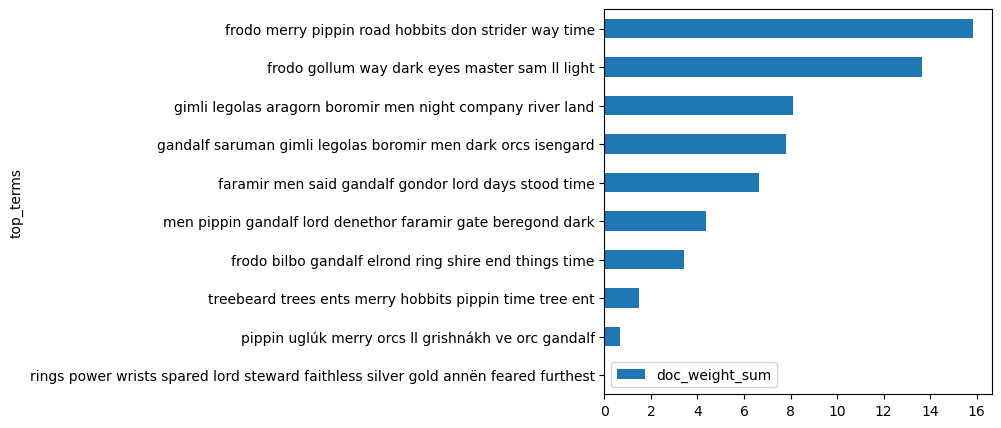

In [76]:
TOPICS.sort_values('doc_weight_sum', ascending=True).plot.barh(y='doc_weight_sum', x='top_terms', figsize=(5, n_topics/2));

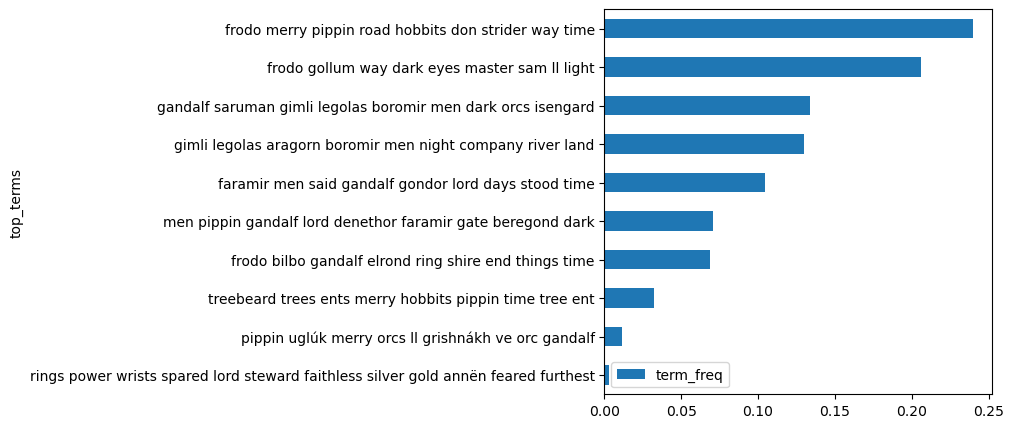

In [77]:
TOPICS.sort_values('term_freq', ascending=True).plot.barh(y='term_freq', x='top_terms', figsize=(5, n_topics/2));

In [81]:
LIB = pd.read_csv('data/LOTR/LIB.csv')

In [83]:
LIB

book_id                  title                        part  \
0        1  The Lord of the Rings  The Fellowship of the Ring   
1        2  The Lord of the Rings  The Fellowship of the Ring   
2        3  The Lord of the Rings              The Two Towers   
3        4  The Lord of the Rings              The Two Towers   
4        5  The Lord of the Rings      The Return of the King   
5        6  The Lord of the Rings      The Return of the King   

             author  year_of_publish  
0  J. R. R. Tolkien  21 October 1954  
1  J. R. R. Tolkien  21 October 1954  
2  J. R. R. Tolkien    21 April 1955  
3  J. R. R. Tolkien    21 April 1955  
4  J. R. R. Tolkien   5 January 1956  
5  J. R. R. Tolkien   5 January 1956

In [84]:
# LDA + PCA VIZ
from sklearn.decomposition import PCA
import plotly.express as px

pca = PCA(n_components=2)  # Use two components
topic_space = pca.fit_transform(PHI)

topic_coords = pd.DataFrame(topic_space, columns=['PC1', 'PC2'], index=PHI.index)
topic_coords['Topic'] = topic_coords.index
topic_coords['Document Weight'] = THETA.mean(axis=0)  # Assuming THETA's columns match PHI's index

# Merge with LIB to get metadata for coloring (assuming there's a 'Genre' column in LIB for example)
topic_coords = topic_coords.join(LIB[['part']], how='left')

# Scatter plot of topics in the first two principal component space
fig = px.scatter(topic_coords, x='PC1', y='PC2', text='Topic', color='part', size='Document Weight',
                 title="PCA of Topics", labels={'PC1': 'Principal Component 1', 'PC2': 'Principal Component 2'})
fig.update_traces(textposition='top center')
fig.show()

In [86]:
TOKENS.to_csv('TOKENS.csv', index=True)

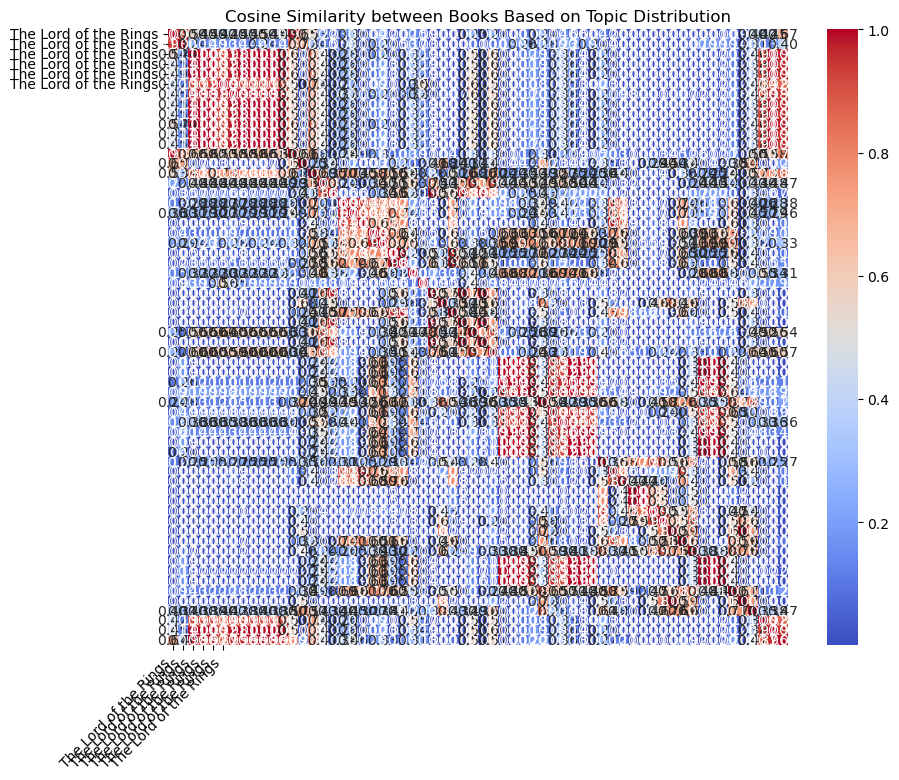

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `THETA` is a DataFrame where rows are books and columns are topic weights
# Compute cosine similarity matrix
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(THETA.values)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=True, fmt=".2f", cmap="coolwarm",
            xticklabels=LIB['title'].values, yticklabels=LIB['title'].values)
plt.title("Cosine Similarity between Books Based on Topic Distribution")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()
